<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using the Landlab NetworkSedimentTransporter component starting with a shapefile river network

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to model the transport of coarse sediment through a river network using the NetworkSedimentTransporter Landlab component. 

In this example we will: 
- load a river network shapefile to create a Landlab grid to represent a river network
- create sediment "parcels" that will transport through the river network, represented as items in a Landlab DataRecord
- run the component
- plot the results of the model run

Import the necessary libraries, plus a bit of magic so that we can plot within this notebook:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
import numpy as np
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile

from landlab.plot import plot_network_and_parcels
%matplotlib inline

## 1. Load a shapefile that represents the river network

First, we need to create a Landlab NetworkModelGrid to represent the river network. Each link on the grid represents a reach of river. Each node represents a break between reaches. All tributary junctions must be associated with grid nodes. 

In [2]:
DATA_DIR = "./data/"
file = os.path.join(DATA_DIR, "MethowSubBasin.shp")

points_shapefile = os.path.join(DATA_DIR, "MethowSubBasin_Nodes_4.shp")
grid = read_shapefile(
    file,
    points_shapefile=points_shapefile,
    node_fields=["usarea_km2", "Elev_m"],
    link_fields=["usarea_km2", "Length_m"],
    link_field_conversion={"usarea_km2": "drainage_area", "Slope":"channel_slope", "Length_m":"reach_length"},
    node_field_conversion={
        "usarea_km2": "drainage_area",
        "Elev_m": "topographic__elevation",
    },
    threshold=0.01,
    )

Alright, let's see what fields we read in with this shapefile:

In [3]:
grid.at_link.keys()

['reach_length', 'drainage_area', 'x_of_polyline', 'y_of_polyline']

In [4]:
grid.at_node.keys()

['drainage_area', 'topographic__elevation']

Great! Looks like we have length (link length), width (channel width), and upstream drainage area (area)

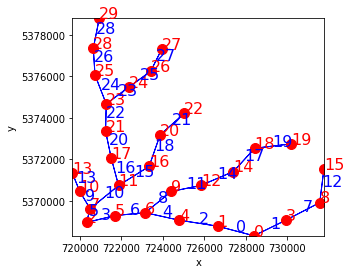

In [5]:
graph.plot_graph(grid, at="node,link")

In [6]:
grid.number_of_links

29

In [7]:
grid.number_of_nodes

30

Our network consists of 29 links between 30 nodes. In the plot above, X and Y represent the plan-view coordinates of the node locations. 

Next, we need to populate the grid with the relevant topographic and hydrologic information: 

In [8]:
grid.at_node["bedrock__elevation"] = grid.at_node["topographic__elevation"].copy()

grid.at_link["channel_width"] = 1 * np.ones(grid.number_of_links)

grid.at_link["flow_depth"] = 0.5 * np.ones(grid.number_of_links)

We must distinguish between topographic elevation (the top surface of the bed sediment) and bedrock elevation (the surface of the river in the absence of modeled sediment). 

Note that "link_length" is defined by the user, rather than calculated as the minimum distance between nodes. This accounts for channel sinuosity. 


## 2. Create sediment 'parcels' in a DataRecord

We represent sediment in the network as discrete parcels (or packages) of grains of uniform size and characteristics. Each parcel is tracked through the network grid according to sediment transport and stratigraphic constraints. 

Parcels are tracked using the Landlab DataRecord tool. For a more detailed tutorial for use of DataRecord, see *** insert link here *** . 

First, let's create arrays with all of the essential sediment parcel variables: 

In [9]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.15 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

In order to track sediment motion, we classify parcels as either active (representing mobile surface sediment) or inactive (immobile subsurface) during each timestep. The active parcels are the most recent parcels to arrive in the link. During a timestep, active parcels are transported downstream (increasing their `location_in_link`, which ranges from 0 to 1) according to a sediment transport formula. 

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [10]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

In addition to the required parcel attributes listed above, you can designate optional parcel characteristics, depending on your needs. For example: 

In [11]:
lithology = ["quartzite"] * np.size(element_id)

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time :

In [12]:
variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

In [13]:
items = {"grid_element": "link", "element_id": element_id}

_OUT_OF_NETWORK = NetworkModelGrid.BAD_INDEX - 1

parcels = DataRecord(
    grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [_OUT_OF_NETWORK]},
)

## 3. Run the NetworkSedimentTransporter

With the parcels and grid set up, we can move on to setting up the model. 

In [14]:
timesteps = 10 # total number of timesteps
dt = 60 * 60 * 24 *2 # length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component: 

In [15]:
fd = FlowDirectorSteepest(grid, "topographic__elevation")
fd.run_one_step()

Then, we initialize the network sediment transporter: 

In [16]:
nst = NetworkSedimentTransporter(    
    grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)

Now we are ready to run the model forward in time: 

In [17]:
for t in range(0, (timesteps * dt), dt):
    nst.run_one_step(dt)
    
    print("Model time: ", t/(60*60*24), "days passed")

Model time:  0.0 days passed
Model time:  2.0 days passed
Model time:  4.0 days passed
Model time:  6.0 days passed
Model time:  8.0 days passed
Model time:  10.0 days passed
Model time:  12.0 days passed
Model time:  14.0 days passed
Model time:  16.0 days passed
Model time:  18.0 days passed


## 4. Plot the model results


There are landlab plotting tools specific to the `NetworkSedimentTransporter`. `plot_network_and_parcels` creates a plan-view map of the network and parcels (represented as dots along the network). We can color both the parcels and the links by attributes.  

Here, we demonstrate a few examples of plotting. For a more complete tutorial on the plotting scripts, see [XXX insert link here]

#### Example A: Uniform color parcels, existing link attribute
In the plot below, each link (represented as a line) is colored by the total volume of sediment on the link. In this example, each parcel is simply colored red. To exclude parcels from the plotting, set `parcel_alpha` equal to 0. The parcel positions and sediment volumes shown are for the last timestep (default `parcel_time_index = -1`)

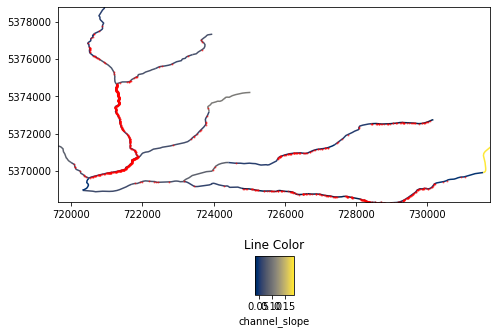

In [75]:
fig = plot_network_and_parcels(
    grid, parcels, 
    parcel_color='r',
    link_attribute="channel_slope")

### XXX Insert example here plotting D grain size log-normalized
#### Example B: Parcel grain size, color on log-normal scale

Explanation here

In [70]:
#use parcel_time_index = 1 (or something like that)

#### Example C: Calculating a new link attribute based on parcel characteristics
In example A, above, `"sediment_total_volume"` is passed as the link_attribute.

We can also color links by values that we calculate. For example, if we are curious about the fate of sediment that started out on link 27, we might want to plot the total volume of sediment that originated on link 27 during a later timestep:

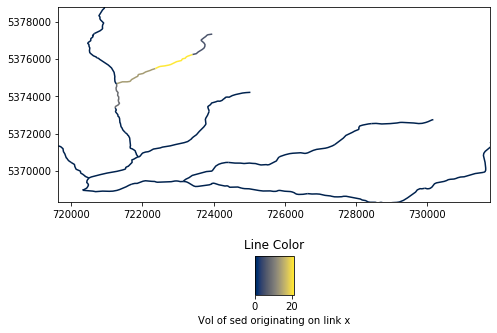

In [74]:
timestep_of_interest = 5
originating_link = 27

#filter the parcels to calculate total volumes of only the parcels that originated in the chosen link
parcelfilter = np.zeros_like(
    parcels.dataset.element_id, dtype=bool
)
parcelfilter[:, timestep_of_interest] = (parcels.dataset.element_id[:,0] == originating_link)

vol_orig_link = parcels.calc_aggregate_value(
            np.sum,
            "volume",
            at="link",
            filter_array=parcelfilter,
            fill_value=0.0
        )

grid.at_link["vol_orig_link"] = vol_orig_link # XXX this line should become unnecessary when I get updates from Katy -- pass an array into link_attribute (rather than assigning grid._at_link above...)

fig = plot_network_and_parcels(
    grid, parcels,
    link_attribute="vol_orig_link", 
    link_attribute_title = "Vol of sed originating on link x",
    parcel_alpha = 0
)

#### Example D: XXX Plot only some of the parcels

Katy will make this possible



In [76]:
# Insert example here

#### Non-network plotting
The results of the NST can be visualized by directly accessing informaiton about the grid, the parcels, and by accessing variables stored after the run of NST. 

As a simple example, we can plot the total volume of parcels on the grid through time. As parcels exit the grid, the total volume decreases.  

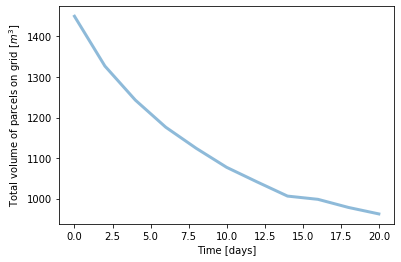

In [77]:
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         np.sum(parcel_vol_on_grid, axis=0),
         '-',
         linewidth=3, 
         alpha=0.5
        )

plt.ylabel('Total volume of parcels on grid $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 

We can also plot individual parcel characteristics. The plot below shows the total transport distance of each parcel through the whole model run as a function of the parcel's grain size (during the final timestep). 

Text(0, 0.5, 'Cumulative parcel travel distance (m)')

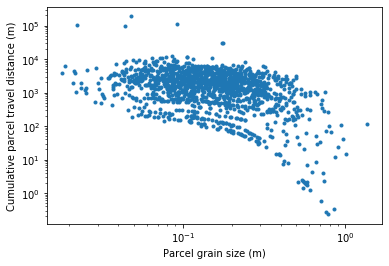

In [80]:
plt.loglog(parcels.dataset.D[:,-1],
         nst._distance_traveled_cumulative,
         '.'
        )
plt.xlabel('Parcel grain size (m)')
plt.ylabel('Cumulative parcel travel distance (m)')

# Note: some of the samllest grain travel distances can exceed the length of the 
# grid by "overshooting" during a single timestep of high transport rate


The plot below is an example of accessing variables associated with the grid (`grid.at_link.X`, or `grid.at_node.X`), as well as a variable associated with this instance of NetworkModelGrid (`nmg.X`):

Text(0, 0.5, 'Mean grain size of active layer (m)')

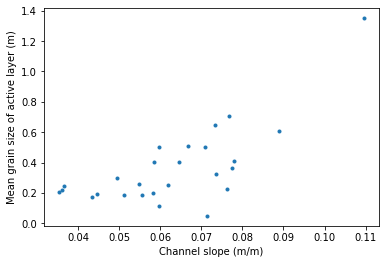

In [78]:
plt.plot(grid.at_link["channel_slope"],
         nst.d_mean_active, 
         '.')
plt.xlabel('Channel slope (m/m)')
plt.ylabel('Mean grain size of active layer (m)')